In [ ]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle/

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
DATASET_PATH = 'https://www.kaggle.com/datasets/prithwirajmitra/covid-face-mask-detection-dataset'
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'leukemia.zip',
      origin="https://www.kaggle.com/datasets/prithwirajmitra/covid-face-mask-detection-dataset",
      extract=True,
      cache_dir='.', cache_subdir='data')

   8192/Unknown - 0s 0us/step

In [ ]:
!kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset

 93% 193M/207M [00:01<00:00, 149MB/s]
100% 207M/207M [00:01<00:00, 167MB/s]


In [ ]:
from zipfile import ZipFile
with ZipFile('/content/covid-face-mask-detection-dataset.zip','r') as zipObj:
  zipObj.extractall('covid-face-mask-detection')

In [ ]:
# Define the file paths for the training and testing data
filepath_train = "/content/covid-face-mask-detection/New Masks Dataset/Train"  # File path for the training data
filepath_test = "/content/covid-face-mask-detection/New Masks Dataset/Test"  # File path for the testing data

In [ ]:
def flow_direc_show(filepath, batch_size, square_size):
    # Create an ImageDataGenerator object to rescale the pixel values of the images
    imggen = ImageDataGenerator(rescale=1./255)
    flow = imggen.flow_from_directory(filepath, target_size=(square_size, square_size), batch_size=batch_size, class_mode='sparse')

    # Return the data flow object
    return flow

In [ ]:
batch_size = 25  # Number of images to include in each batch
square_size = 200  # Size of the images after resizing
seegen = flow_direc_show(filepath_train, batch_size, square_size)

Found 600 images belonging to 2 classes.


In [ ]:
def flow_direc(filepath, batch_size, square_size):
    imggen = ImageDataGenerator(preprocessing_function=preprocess_input)
    flow = imggen.flow_from_directory(filepath, target_size=(square_size, square_size), batch_size=batch_size, class_mode='sparse')
    return flow


In [ ]:
train_gen = flow_direc(filepath_train, batch_size, square_size)

# Create an image data generator and a corresponding data flow for the testing data using the flow_direc function defined earlier
test_gen = flow_direc(filepath_test, batch_size, square_size)

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
def see_image(gen):
    for i in range(0, len(gen)):
        img, label = gen.next()
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i].astype(np.float64))
        if label[i] == 0:
            t = "mask"
        else:
            t = "no_mask"
        plt.title(t)

        # Turn off the axis labels for the current subplot
        plt.axis("off")

    # Display the grid of subplots
    plt.show()

In [ ]:
resnet_model = tf.keras.applications.InceptionResNetV2(input_shape=(square_size, square_size, 3), include_top=False, weights='imagenet')

# Create a sequential model
model = Sequential()

# Add the pre-trained InceptionResNetV2 model to the sequential model
model.add(resnet_model)

# Add a flatten layer to the sequential model
model.add(Flatten())

# Add a fully connected layer with 200 units and a ReLU activation function to the sequential model
model.add(Dense(200, activation="relu"))

# Add a fully connected layer with 50 units and a ReLU activation function to the sequential model
model.add(Dense(50, activation="relu"))

# Add a fully connected layer with 2 units and a softmax activation function to the sequential model
model.add(Dense(2, activation="softmax"))
# Print a summary of the sequential model
model.summary()

# Compile the model with the specified loss function, optimizer, and evaluation metric
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


219055592/219055592 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 24576)             0         
                                                                 
 dense (Dense)               (None, 200)               4915400   
                                                                 
 dense_1 (Dense)             (None, 50)                10050     
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 59,262,288
Trainable params: 59,201,744
N

In [ ]:
earlystop = EarlyStopping(monitor="val_loss", patience=10)

# Define a learning rate reduction callback to reduce the learning rate by a factor of 0.5 if the validation accuracy does not improve for 2 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

# Define a checkpoint callback to save the model with the best validation accuracy during training
checkpoint = ModelCheckpoint('./models/sudoscan.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

In [ ]:
model.fit(train_gen, epochs=5, validation_data=test_gen, callbacks=[earlystop, checkpoint, learning_rate_reduction])

Epoch 1/5
24/24 [==============================] - 341s 14s/step - loss: 0.2398 - accuracy: 0.9600 - val_loss: 119390.7969 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/5
24/24 [==============================] - 339s 14s/step - loss: 0.0972 - accuracy: 0.9667 - val_loss: 23.9421 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/5
24/24 [==============================] - 344s 14s/step - loss: 0.0793 - accuracy: 0.9833 - val_loss: 121.5197 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 4/5
24/24 [==============================] - 330s 14s/step - loss: 0.9387 - accuracy: 0.9633 - val_loss: 2.3499 - val_accuracy: 0.7700 - lr: 0.0010
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.7584 - accuracy: 0.9200 
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
24/24 [==============================] - 338s 14s/step - loss: 0.7584 - accuracy: 0.9200 - val_loss: 5486816.5000 - val_accuracy: 0.5400 - lr: 0.0010


In [ ]:
modelfilepath="mask_recog.h5"

In [ ]:
model.save(filepath=modelfilepath)

In [ ]:
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
from google.colab.patches import cv2_imshow

faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml")
model = load_model("/content/face_mask_detection/mask_recog.h5")

def face_mask_detector(frame):
  # frame = cv2.imread(fileName)
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  faces = faceCascade.detectMultiScale(gray,
                                        scaleFactor=1.1,
                                        minNeighbors=5,
                                        minSize=(60, 60),
                                        flags=cv2.CASCADE_SCALE_IMAGE)
  faces_list=[]
  preds=[]
  for (x, y, w, h) in faces:
      face_frame = frame[y:y+h,x:x+w]
      face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
      face_frame = cv2.resize(face_frame, (224, 224))
      face_frame = img_to_array(face_frame)
      face_frame = np.expand_dims(face_frame, axis=0)
      face_frame =  preprocess_input(face_frame)
      faces_list.append(face_frame)
      if len(faces_list)>0:
          preds = model.predict(faces_list)
      for pred in preds:
          (mask, withoutMask) = pred
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
      cv2.putText(frame, label, (x, y- 10),
                  cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

      cv2.rectangle(frame, (x, y), (x + w, y + h),color, 3)
  # cv2_imshow(frame)
  return frame

In [ ]:
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
from google.colab.patches import cv2_imshow

faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml")
model = load_model("mask_recog.h5")

def face_mask_detector(frame):
  # frame = cv2.imread(fileName)
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  faces = faceCascade.detectMultiScale(gray,
                                        scaleFactor=1.1,
                                        minNeighbors=5,
                                        minSize=(60, 60),
                                        flags=cv2.CASCADE_SCALE_IMAGE)
  faces_list=[]
  preds=[]
  for (x, y, w, h) in faces:
      face_frame = frame[y:y+h,x:x+w]
      face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
      face_frame = cv2.resize(face_frame, (224, 224))
      face_frame = img_to_array(face_frame)
      face_frame = np.expand_dims(face_frame, axis=0)
      face_frame =  preprocess_input(face_frame)
      faces_list.append(face_frame)
      if len(faces_list)>0:
          preds = model.predict(faces_list)
      for pred in preds:
          (mask, withoutMask) = pred
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
      cv2.putText(frame, label, (x, y- 10),
                  cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

      cv2.rectangle(frame, (x, y), (x + w, y + h),color, 3)
  # cv2_imshow(frame)
  return frame

1/1 [==============================] - 1s 790ms/step


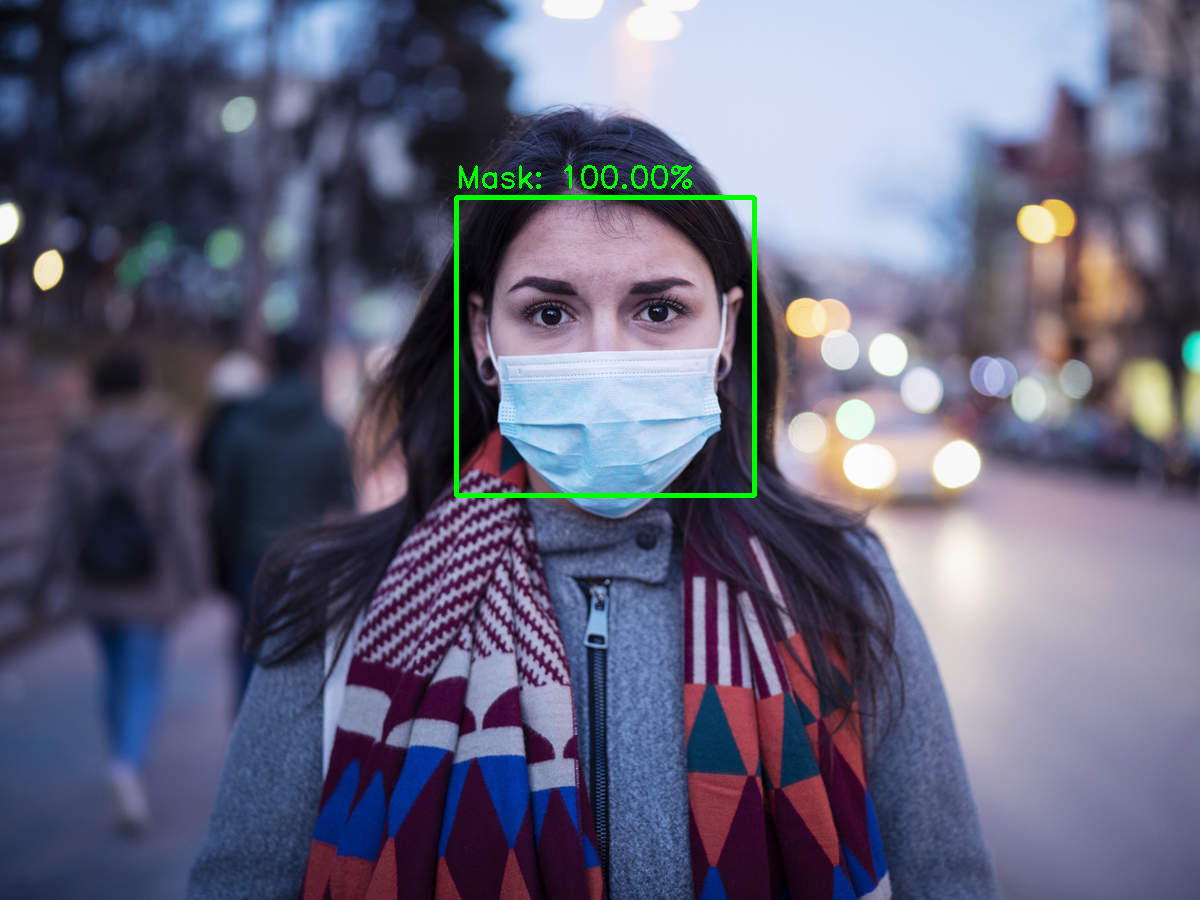

In [ ]:
input_image = cv2.imread("image.jpg")
output = face_mask_detector(input_image)
cv2_imshow(output)

1/1 [==============================] - 0s 40ms/step


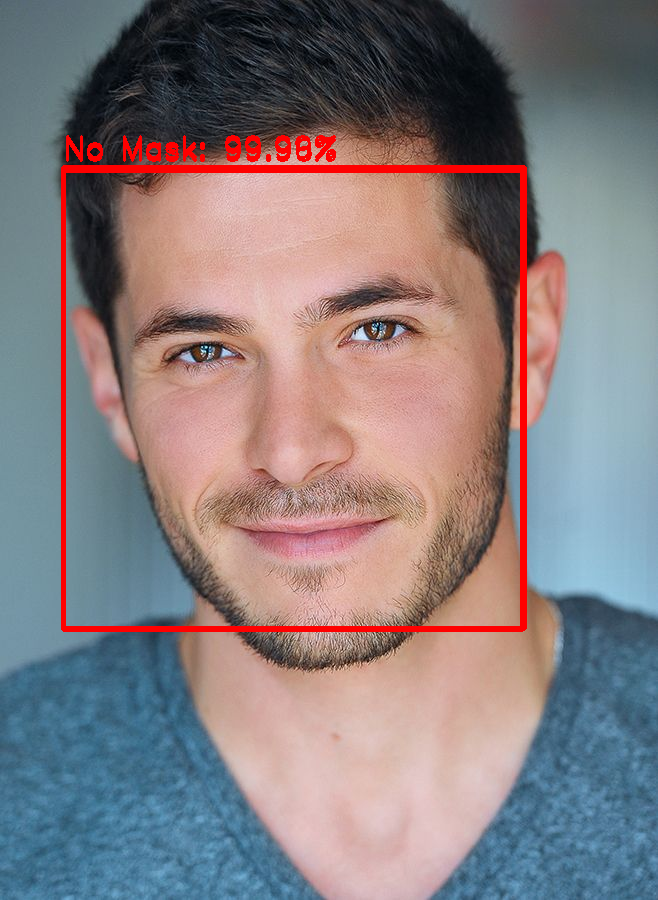

In [ ]:
input_image = cv2.imread("image3.png")
output = face_mask_detector(input_image)
cv2_imshow(output)

In [ ]:
cap = cv2.VideoCapture('video.mp4')
ret, frame = cap.read()
frame_height, frame_width, _ = frame.shape
out = cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
print("Processing Video...")
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    out.release()
    break
  output = face_mask_detector(frame)
  out.write(output)
out.release()
print("Done processing video")